<a href="https://colab.research.google.com/github/Maryush9/y2_2022/blob/main/experiment_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
#@title Imports
import numpy as np    # library for numerical computations (vectors, matrices, tensors)
import pandas as pd    # library for data manipulation and analysis
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive') 
import os
import math
from scipy import interpolate
from scipy.fft import fft, fftfreq, fftshift, ifft
from importlib import reload
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import IPython.display
from IPython.display import display, clear_output


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
#@title Copying "predicitons" data of results form the folder
#@markdown makes a data_dict dictionary with the name of a trial (key) and pandas dataframe of a trial
path = '/content/drive/MyDrive/Maria Gabriel/Data' #default path to the root of Drive
data_dict = {} 
while True:
    try:
        os.chdir(path)
    except:
        break
    fileList = os.listdir()
    # for item in fileList:
    us = widgets.Dropdown(options = fileList, value=None, description='Select folder :')
    def lala(user):
      try:
        selectedFilePath = '/content/drive/MyDrive/Maria Gabriel/Data/'+ user

        os.chdir(user)
        data_dict.clear()                         # cleans the dictionary, for reusing the code (changing folder)
        print('selectFile ', selectedFilePath)
        a = os.listdir()
        for i in sorted(a):
          if os.path.isdir(i):
            data_dict[i] = pd.read_csv(selectedFilePath + '/' + i + '/' + 'predictions.csv')
        os.chdir('/content/drive/MyDrive/Maria Gabriel/Data')
      except TypeError:
        print('Argument is missing\nPlease select folder')

          
    widgets.interact(lala, user = us)



    break

interactive(children=(Dropdown(description='Select folder :', options=('071522 PLR spectral sensitivity 1e-4 R…

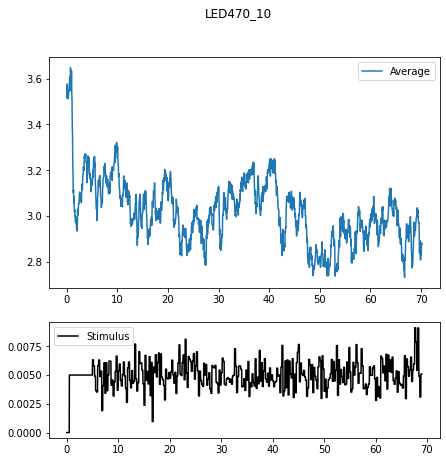

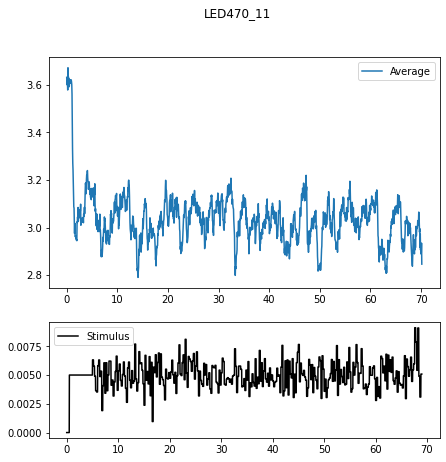

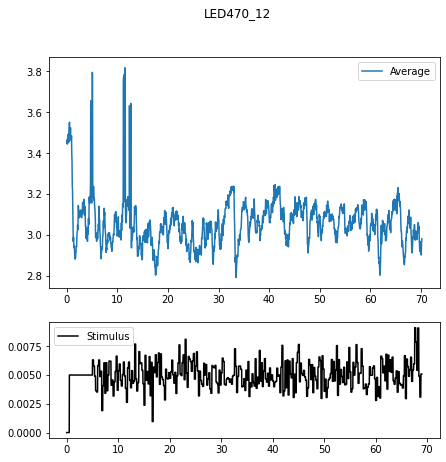

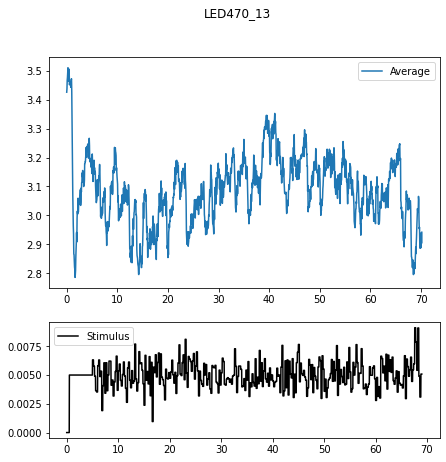

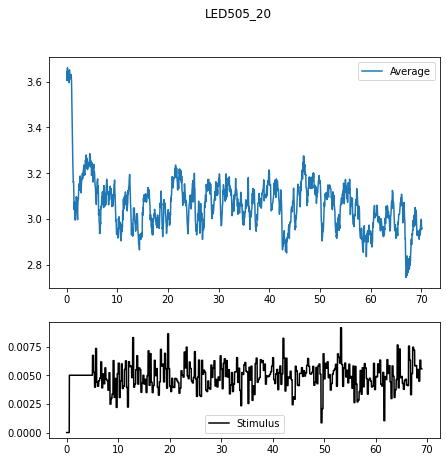

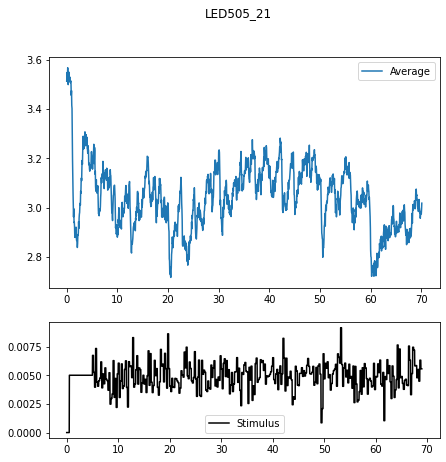

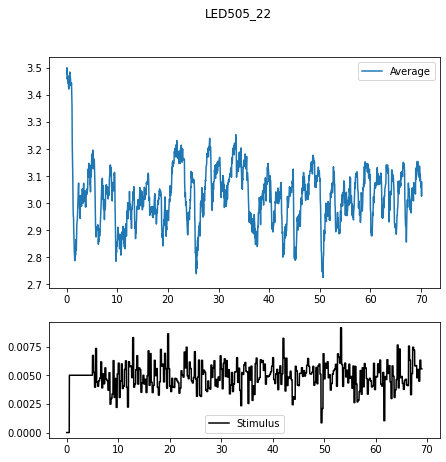

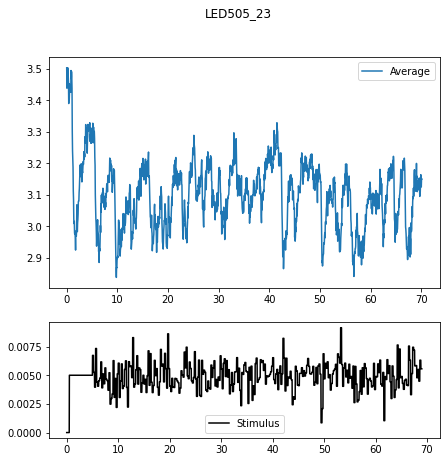

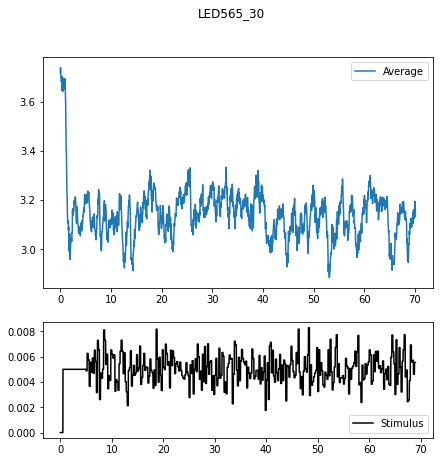

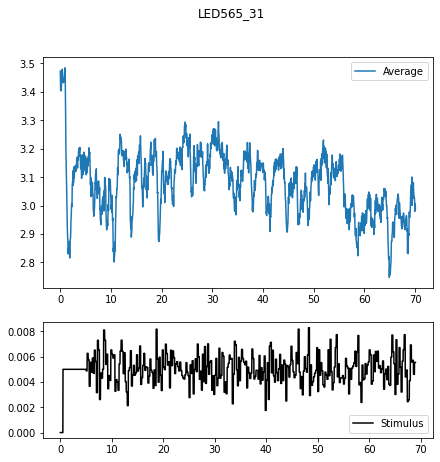

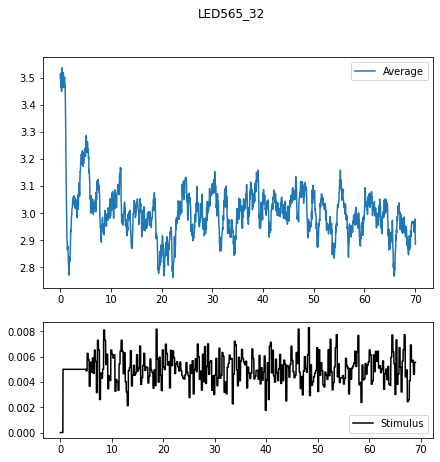

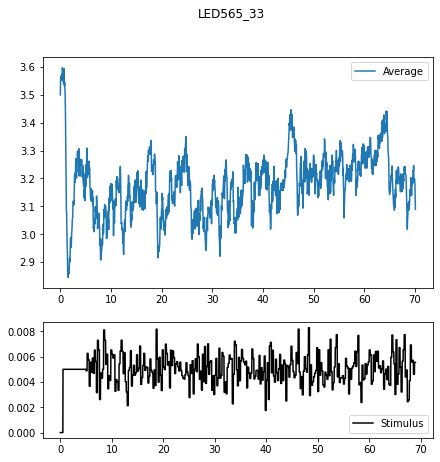

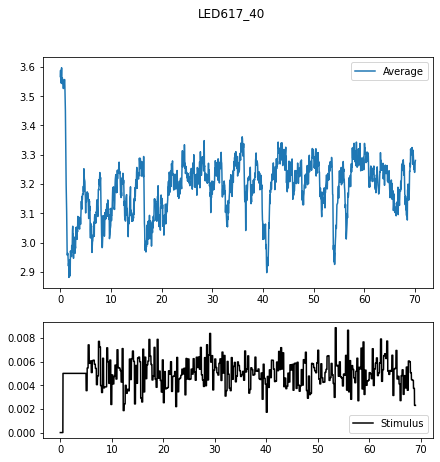

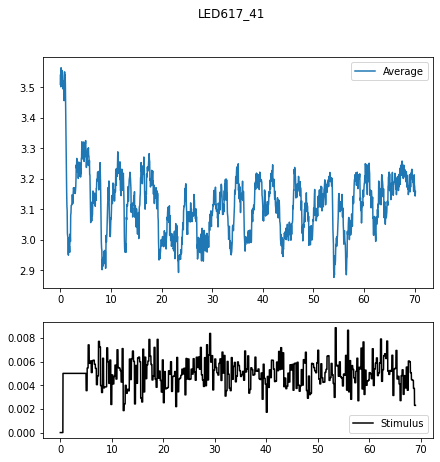

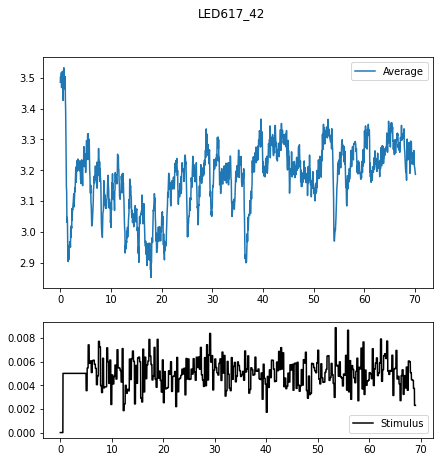

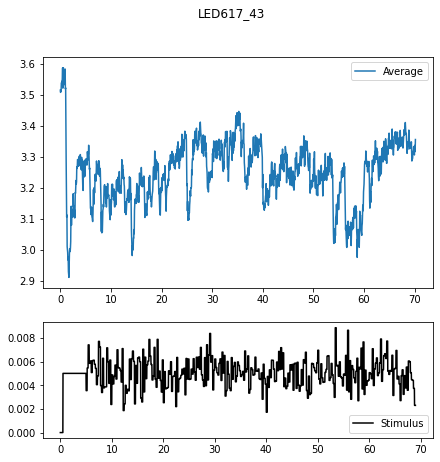

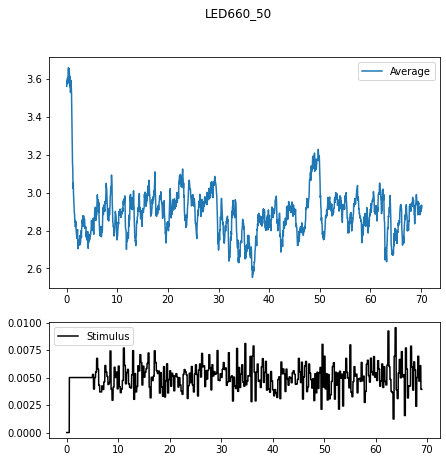

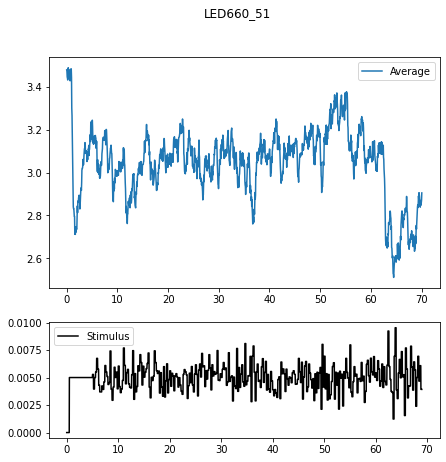

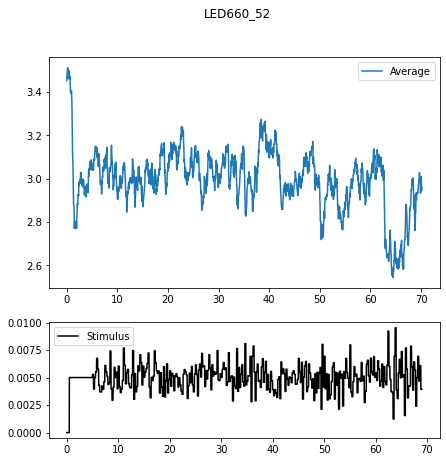

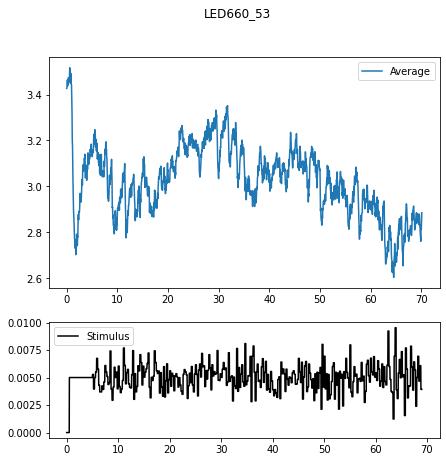

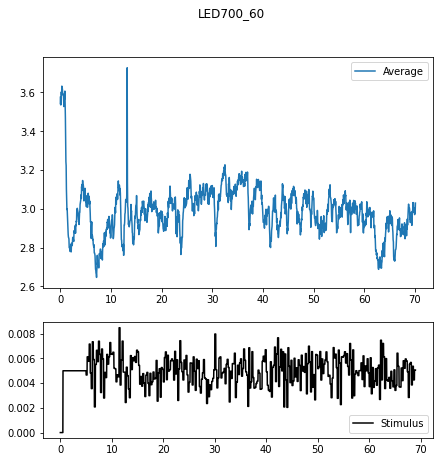

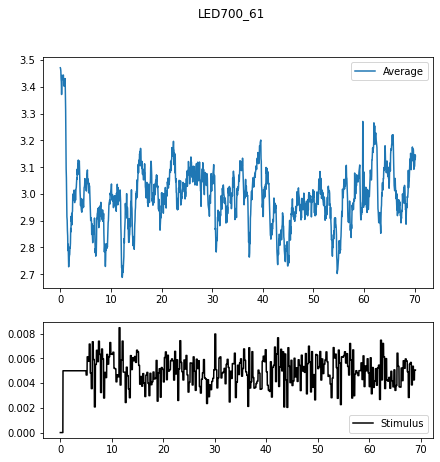

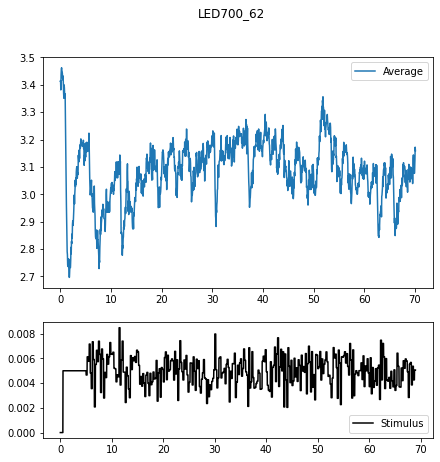

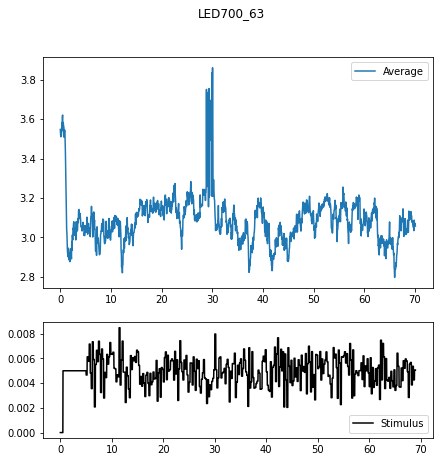

In [85]:
#@title Print downloaded LED files
 
for i in data_dict:
  comp_plot(data_dict[i], ['Average'], i)




##Esential programs

In [ ]:
def check_stim(dta):                     #basicaly  program just changes name of the column 'stim' to 'stimulus'
  if 'stimulus' not in dta.keys():
    dta.rename(columns = {'stim':'stimulus'}, inplace = True)

  elif 'Average' not in dta.keys():
    dta.rename(columns = {'average':'Average'}, inplace = True)  
  return dta

In [ ]:
def adding_points(a, scale):  #a is a numpy array, scale is an integer
                              # 

  step = 1/scale
  b = []
  for p in a:
    for i in range(int(scale)):
        b.append(p)

  x = np.arange(0, 5 , step)
  return b



In [ ]:
def skipping_points(a, scale):
  arr = np.empty((len(a)))

  for i in range(len(a)):
    if (i / scale)%1 == 0:
      arr[i] = a[i]
    else:

      arr[i] = np.NaN
  arr = arr[~np.isnan(arr)]
  return arr
      

In [81]:
#@title The comparing program 
#@markdown Has three parameters: the dataframe, columns' names in the list format and the title
#
def comp_plot(data, column_list, title, **kwargs):
  [from_t, to_t] = kwargs.get('subrange',[0,-1])

  stim = data['stimulus']
  x_stim = data['stim_time']#data[data.columns[12]]
  x_data = data['time_s']
  dx_stim = x_stim[1]
  dx_data = x_data[1]

  fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(7, 7))
  fig.suptitle(title)

  for column in column_list:
    axs[0].plot(x_data[int(from_t/dx_data):int(to_t/dx_data)], 
                data[column][int(from_t/dx_data):int(to_t/dx_data)],
                label = column)
  axs[0].legend(loc='upper right')
  

  axs[1].plot(x_stim[int(from_t/dx_stim):int(to_t/dx_stim)],
              stim[int(from_t/dx_stim):int(to_t/dx_stim)],
              label = 'Stimulus', 
              color = 'k')
  plt.legend()
  plt.show()  


###calculate_experiment_filter code

In [ ]:
#@title Calculate_experiment_filter code
#@markdown gets data, timewindow and colum names as a features. Returns dataframe with filters for different columns

def calculate_experiment_filter(starting_time, end_time, results_dataframe, col_list):
  filter_dict = {}                       ## Temporal filters dictionary !!Change name to filter_dict
  dta = results_dataframe
  dta = check_stim(dta)               ##program changes name 'stim' to 'stimulus' if there is no stimulus-named column from the start

  stim = dta['stimulus'].dropna() 
  stim_t = dta['stim_time'].dropna().to_numpy()
  stim_dt = stim_t[1]                           ## sampling interval of stimulus
  stim = stim.to_numpy()


  t = dta['time_s'].dropna()                    ## target x-axis 
  dt = t[1]                                     ## sampling interval of target data
  n = len(t[int(starting_time/dt): int(end_time/dt)])
  add = int(stim_dt/dt)

  # comparing the sampling rate between stimulus and results. Adding or skipping points in stimulus
  # to fit result data 

  if len(stim_t) < len(t):
    if (stim_dt/dt)% 1 != 0 or stim_dt == 0:
      print('not an apropriate data')
      return ValueError

    else:
      stim = adding_points(stim, add)
      xx = np.arange(0, stim_t[-1]+stim_dt, stim_dt/add)
      stim_new_dt = stim_dt/add


  elif len(stim_t) >len(t):
    if (dt/stim_dt)% 1 != 0 or stim_dt == 0:
      print('not an apropriate data')
      return ValueError

    else:

      skip_factor = int(dt/stim_dt)                                         # Skip_factor tells how many points stim data is bigger than result 
                                                                            # in skipping points every nth is skipped according to the factor
      stim_new_dt = stim_dt * skip_factor
      stim = skipping_points(stim, skip_factor)

      
  stim_full_FFT = fft(stim)

  stim_FFT = fft(stim[int(starting_time/dt): int(end_time/dt)])             # getting fft from stimulus, only neded timewindow 
  stim_FFT_conj = np.conj(stim_FFT)

  for trial_name in col_list:
    data = dta[trial_name].dropna()  #
    
    target_FFT = fft(data[int(starting_time/dt): int(end_time/dt)].to_numpy())#, len(stim_FFT_conj))


    filter = target_FFT * stim_FFT_conj
   
    temporal_filter = ifft(filter)
    filter_dict[trial_name] = temporal_filter.astype('float64')
  temporal_filters_DF = pd.DataFrame(filter_dict)
  return temporal_filters_DF

In [ ]:
#@title Baseline 
#@markdown is getting:
#@markdown a ist of  arrays, needed to be zeroed, 
#@markdown delta_x to get right points and time window

def baseline(arr_list, dx, time):
  from_t = time[0]
  to_t = time[1]
  new_list = []
  for arr in arr_list:
    # print('format', arr.type())
    part = []
    part = arr_list[arr][int(from_t/dx):int(to_t/dx)]
    new_arr = part - np.average(part)
    new_list.append(new_arr)
  return new_list


Add optional (kwarg) parameter to plot only subrange, for example from 5 to 10 seconds

###Zeroing code Baseline

###Plotting stimulus vs resluts

In [ ]:
#@title Claculate and plot filter
  
def calculate_and_plot_filter(dta, name, col_list):
  col_list = ['LE_radius_thresh', 'Average']#, 'RE_radius_thresh', 'RE_radius_thresh_despiked']#['RE_radius_thresh']#  #list of needed columns to be analyzed

  calc_from =   5#@param {type:"number"}                       # window for calculating the filter a = start
  calc_to =    69 #@param {type:"number"}                       # b = end
  plot_from =  0  #@param {type:"number"}               # this is the boundary of a plotting window 
  plot_to =    5  #@param {type:"number"}
  dta = check_stim(dta)
  filter = calculate_experiment_filter(calc_from, calc_to, dta, col_list) # program gets a and b as a time window neede to be filtered,
                                                            # data with all columns and column list,
                                                            # that are interesting for the analysis.
                                                           
   # Program returns a pandas dataframe with filters of all columns 
  reload(plt)
  xt = dta['time_s'].dropna()
  xt = xt[:len(xt)-3]
  xt_dt = xt[1]

  plot_filter(filter, xt, [plot_from, plot_to], col_list, name)

  # for i in filter:
  #   plt.title('Temporal filters dictionary') 
  #   plt.plot(filter[i][int(plot_from/xt_dt) : int(plot_to/xt_dt)], label = i)
  #   plt.legend()
  # plt.figure(figsize=(10, 6))

  # plt.show()
  return filter



##Plotting filters

In [ ]:
#@title Plots zeroed
def plot_filter(filter, xt, plot_ft, col_list, name):
  a = 5
  plot_from = plot_ft[0]
  plot_to = plot_ft[1]
  xt_dt = xt[1]
  zh = baseline(filter, xt_dt, [plot_from, plot_to])
  for i in range (len(col_list)):
    plt.plot(xt[int(a + plot_from/xt_dt):int(a + plot_to/xt_dt)], zh[i],label = col_list[i])

  plt.xlabel('time [s]') 
  plt.ylabel('zeroed amplitude') 
  plt.title('filter for a wavelngth ' + name)
  plt.legend()
  plt.show()

In [ ]:
#@title Calculates and plots all flters
filters_dict = data_dict.copy()
for trial in data_dict:
  filter = calculate_and_plot_filter(data_dict[trial], trial, col_list)
  filters_dict[trial] = filter




# print(filters_df.columns.to_list())

In [ ]:
ll = list(filters_dict.keys())
# print(ll[0])
columns = list(filters_dict[ll[0]].keys())



['LE_radius_thresh', 'Average']


In [ ]:
#@title Plotts all averages of filters of same LED on one plot
col_list = ['Average']
for trial in filters_dict:
  plt.plot(xt[int(a + plot_from/xt_dt):int(a + plot_to/xt_dt)], zh[i],label = col_list[i])

plt.xlabel('time [s]') 
plt.ylabel('zeroed amplitude') 
plt.title('filter for a wavelngth ' + name)
plt.legend()
plt.show()

LED470_10 LED470_11 LED470_12 LED470_13 LED505_20 LED505_21 LED505_22 LED505_23 LED565_30 LED565_31 LED565_32 LED565_33 LED617_40 LED617_41 LED617_42 LED617_43 LED660_50 LED660_51 LED660_52 LED660_53 LED700_60 LED700_61 LED700_62 LED700_63


##Just some tests

In [ ]:

columns_chosen = []
opt =  widgets.SelectMultiple(
    options = columns_list,
    value=['Average'],
    #rows=10,
    description='Fruits',
    disabled=False
)

def func(colum):
  
  for i in colum:
    columns_chosen.append(i)
  return columns_chosen   

widgets.interact(func, colum = opt)



In [ ]:

#@title Copying data form the folder
#@markdown old version
# path = '/content/drive/MyDrive/Maria Gabriel/Data' #default path to the root of Drive
# data_dict = {} 
# while True:
#     try:
#         os.chdir(path)
#     except:
#         break
#     fileList = os.listdir()
#     i = 1
#     for item in fileList:
#         print('['+str(i)+'] '+item)
#         i+=1
#     user = input('\nEnter the number of the file/folder: ')
#     selectedFilePath = '/content/drive/MyDrive/Maria Gabriel/Data/'+ fileList[int(user) - 1]
#     os.chdir(fileList[int(user) - 1])
#     print('selectFile ', selectedFilePath)
#     a = os.listdir()
#     for i in sorted(a):
#       if os.path.isdir(i):
#         data_dict[i] = pd.read_csv(selectedFilePath + '/' + i + '/' + 'predictions.csv')


#     break


interactive(children=(SelectMultiple(description='Fruits', index=(10,), options=('LE_radius_thresh', 'LE_radiu…

None this is the list
